In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler

In [270]:
#importing dataset
df_myDataset = pd.read_csv('raw_merged_heart_dataset.csv')
#Showing Dataset
print(df_myDataset.head(10))

   age  sex  cp trestbps chol fbs restecg thalachh exang  oldpeak slope ca  \
0   63    1   3      145  233   1       0      150     0      2.3     0  0   
1   37    1   2      130  250   0       1      187     0      3.5     0  0   
2   41    0   1      130  204   0       0      172     0      1.4     2  0   
3   56    1   1      120  236   0       1      178     0      0.8     2  0   
4   57    0   0      120  354   0       1      163     1      0.6     2  0   
5   57    1   0      140  192   0       1      148     0      0.4     1  0   
6   56    0   1      140  294   0       0      153     0      1.3     1  0   
7   44    1   1      120  263   0       1      173     0      0.0     2  0   
8   52    1   2      172  199   1       1      162     0      0.5     2  0   
9   57    1   2      150  168   0       1      174     0      1.6     2  0   

  thal  target  
0    1       1  
1    2       1  
2    2       1  
3    2       1  
4    2       1  
5    1       1  
6    2       1  
7    

In [271]:
# Replacing '?' with NaN across the entire DataFrame
df_myDataset = df_myDataset.replace('?', np.nan)

# Converting all columns in the dataset to numeric, coerce errors to NaN for non-numeric values
df_myDataset = df_myDataset.apply(pd.to_numeric, errors='coerce')

# Dropping any rows or columns with missing value.
df_myDataset = df_myDataset.dropna()

# Checking for any null values in the dataset
null_values = df_myDataset.isnull().any().any()
if null_values == True:
    print("Dataset has null values")
else:
    print("Dataset has no null values")

#Showing Dataset
print(df_myDataset.head(10))

Dataset has no null values
   age  sex  cp  trestbps   chol  fbs  restecg  thalachh  exang  oldpeak  \
0   63    1   3     145.0  233.0  1.0      0.0     150.0    0.0      2.3   
1   37    1   2     130.0  250.0  0.0      1.0     187.0    0.0      3.5   
2   41    0   1     130.0  204.0  0.0      0.0     172.0    0.0      1.4   
3   56    1   1     120.0  236.0  0.0      1.0     178.0    0.0      0.8   
4   57    0   0     120.0  354.0  0.0      1.0     163.0    1.0      0.6   
5   57    1   0     140.0  192.0  0.0      1.0     148.0    0.0      0.4   
6   56    0   1     140.0  294.0  0.0      0.0     153.0    0.0      1.3   
7   44    1   1     120.0  263.0  0.0      1.0     173.0    0.0      0.0   
8   52    1   2     172.0  199.0  1.0      1.0     162.0    0.0      0.5   
9   57    1   2     150.0  168.0  0.0      1.0     174.0    0.0      1.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0       1  
1    0.0  0.0   2.0       1  
2    2.0  0.0   2.0       1  
3    2.0  0.0   

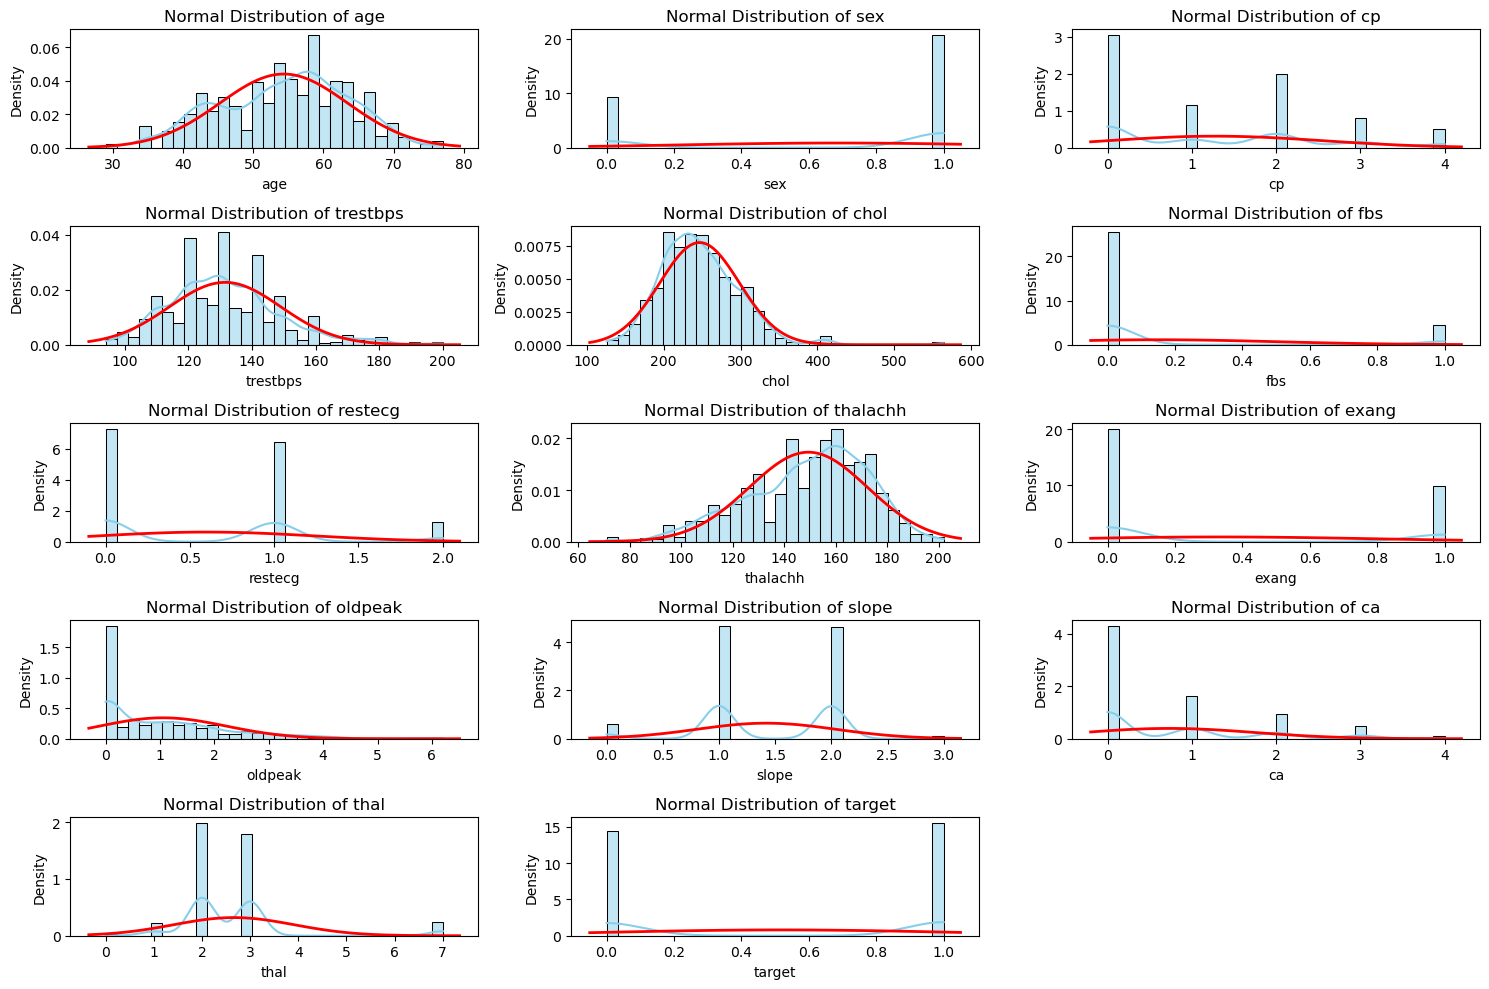

In [272]:
# Plotting the normal distribution for each column in the dataset
numeric_columns = df_myDataset.select_dtypes(include=[np.number]).columns  # Select only numeric columns

# Creating subplots for each numeric column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  # Arrange in a grid
    sns.histplot(df_myDataset[col].dropna(), kde=True, stat="density", bins=30, color='skyblue')  # Plot histogram

    # Overlaying normal distribution curve
    mean = df_myDataset[col].mean()
    std_dev = df_myDataset[col].std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std_dev)
    plt.plot(x, p, 'r', linewidth=2)  # Normal curve in red for distinction

    # Setting titles and labels
    plt.title(f'Normal Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

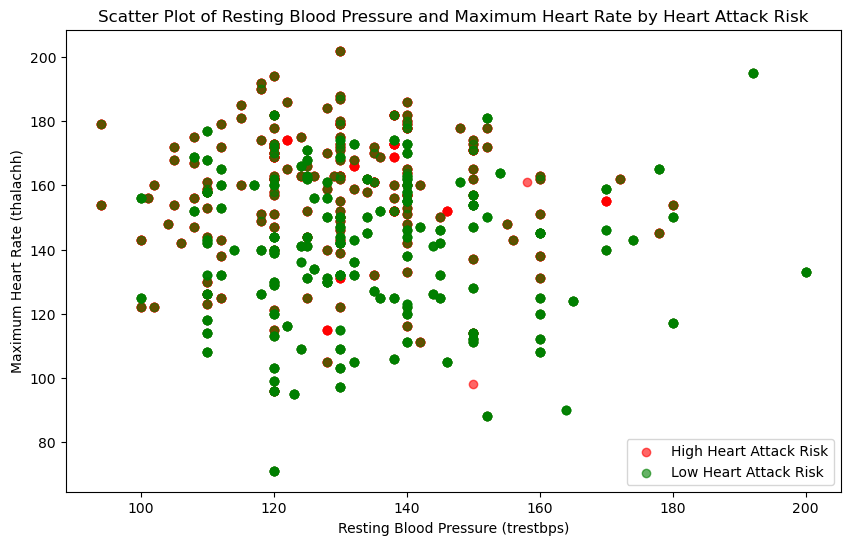

<Figure size 1000x600 with 0 Axes>

In [273]:
# Creating a scatter plot with 'trestbps' on the x-axis, 'thalachh' on the y-axis, and color representing 'target'
plt.figure(figsize=(10, 6))

# Plotting high-risk patients (target = 1) in red
plt.scatter(df_myDataset[df_myDataset['target'] == 1]['trestbps'],
            df_myDataset[df_myDataset['target'] == 1]['thalachh'],
            color='red', label='High Heart Attack Risk', alpha=0.6)

# Plotting low-risk patients (target = 0) in green
plt.scatter(df_myDataset[df_myDataset['target'] == 0]['trestbps'],
            df_myDataset[df_myDataset['target'] == 0]['thalachh'],
            color='green', label='Low Heart Attack Risk', alpha=0.6)

# Settting plot title and labels
plt.title('Scatter Plot of Resting Blood Pressure and Maximum Heart Rate by Heart Attack Risk')
plt.xlabel('Resting Blood Pressure (trestbps)')
plt.ylabel('Maximum Heart Rate (thalachh)')
plt.legend()

# Showing the plot
plt.figure(figsize=(10, 6))
plt.show()

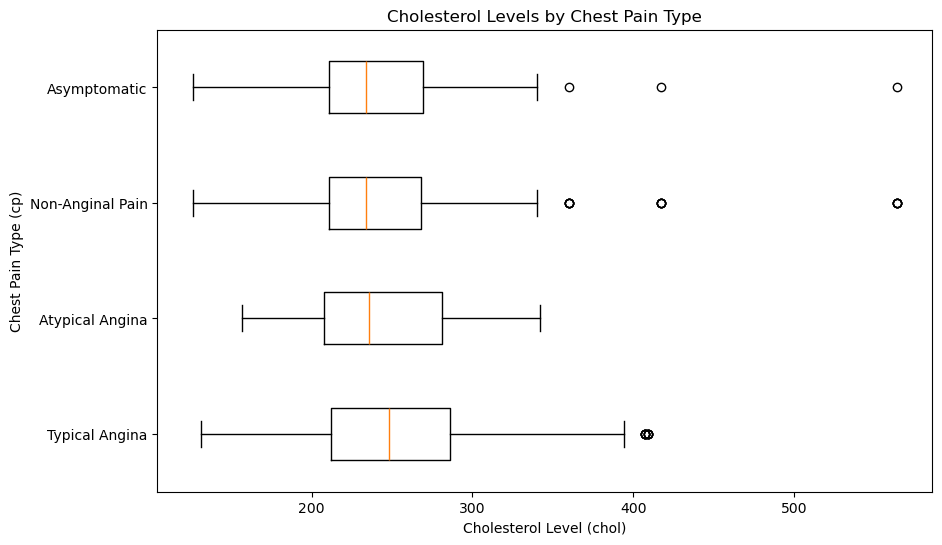

In [274]:
# Plotting Box plot on Cholesterol Levels by Chest Pain Type
# Defining the chest pain types to include
included_categories = [0, 1, 2, 3]

# Filtering the dataset to include only specified chest pain types (cp)
df_filtered = df_myDataset[df_myDataset['cp'].isin(included_categories)]

# Preparing data for the boxplot based on 'chol' levels by chest pain type
data = [df_filtered[df_filtered['cp'] == i]['chol'] for i in included_categories]

# Creating the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=['Typical Angina', 'Atypical Angina', 'Non-Anginal Pain', 'Asymptomatic'], vert=False)

# Customizing plot labels and title for clarity
plt.title('Cholesterol Levels by Chest Pain Type')
plt.xlabel('Cholesterol Level (chol)')
plt.ylabel('Chest Pain Type (cp)')

plt.show()

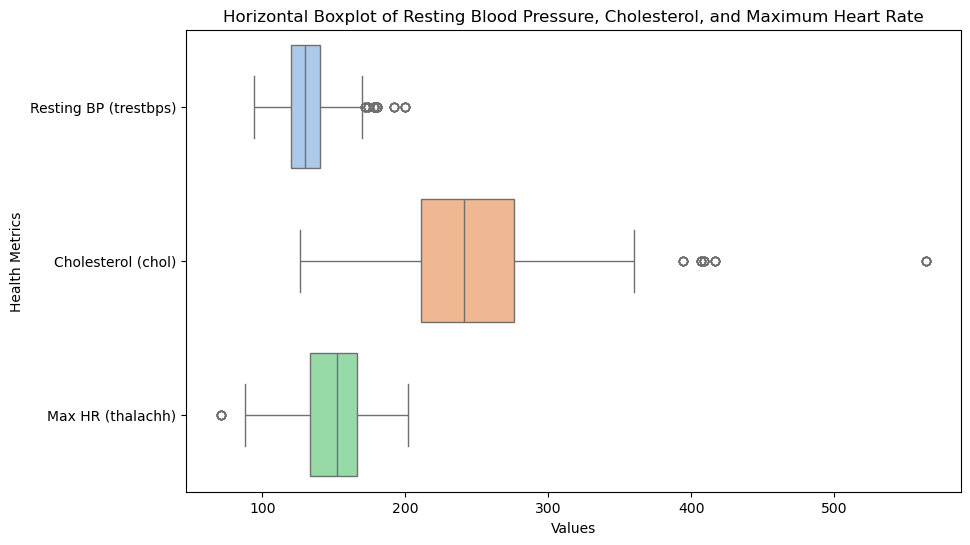

In [275]:
# Creating a boxplot for columns 'trestbps', 'chol', and 'thalachh'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_myDataset[['trestbps', 'chol', 'thalachh']], orient='h', palette='pastel')

# Customizing the plot
plt.title('Horizontal Boxplot of Resting Blood Pressure, Cholesterol, and Maximum Heart Rate')
plt.ylabel('Health Metrics')
plt.xlabel('Values')
plt.yticks([0, 1, 2], ['Resting BP (trestbps)', 'Cholesterol (chol)', 'Max HR (thalachh)'])
plt.show()

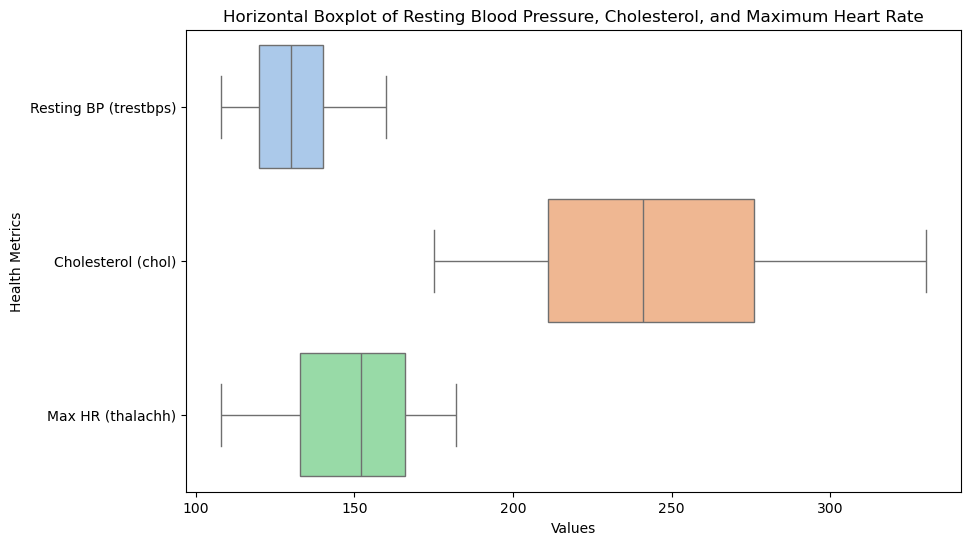

In [276]:
# Capping Outliers
columns_to_cap = ['trestbps', 'chol', 'thalachh']

for col in columns_to_cap:
    lower_bound = df_myDataset[col].quantile(0.05)
    upper_bound = df_myDataset[col].quantile(0.95)
    df_myDataset[col] = df_myDataset[col].clip(lower=lower_bound, upper=upper_bound)

# Creating Box plot after capping outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_myDataset[['trestbps', 'chol', 'thalachh']], orient='h', palette='pastel')

# Customizing the plot
plt.title('Horizontal Boxplot of Resting Blood Pressure, Cholesterol, and Maximum Heart Rate')
plt.ylabel('Health Metrics')
plt.xlabel('Values')
plt.yticks([0, 1, 2], ['Resting BP (trestbps)', 'Cholesterol (chol)', 'Max HR (thalachh)'])
plt.show()

In [277]:
# Exporting the modified dataset to a CSV file
df_myDataset.to_csv('modified_heart_dataset.csv', index=False)

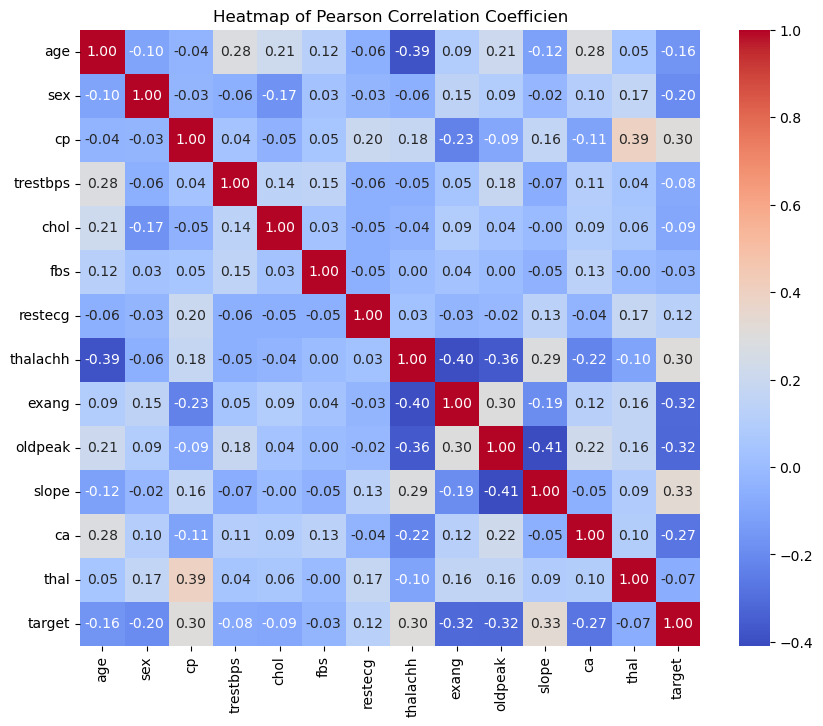

Features selected based on correlation analysis: ['cp', 'thalachh', 'exang', 'oldpeak', 'slope', 'ca', 'target']


In [278]:
# Displaying Heatmap
# Dropping the ID column
if 'ID' in df_myDataset.columns:
    df_myDataset = df_myDataset.drop(columns=['ID'])

# Calculating the Pearson correlation matrix
correlation = df_myDataset.corr()

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Pearson Correlation Coefficien')
plt.show()

# Selecting features with a correlation above 0.2 or below -0.2 with the target variable
correlation_threshold = 0.2
target_corr = correlation['target'].abs()  # Absolute values for simplicity
relevant_features_corr = target_corr[target_corr > correlation_threshold].index.tolist()

print("Features selected based on correlation analysis:", relevant_features_corr)

In [279]:
# GaussianNB
# Separating features and target variable
X = df_myDataset.drop(columns=['target','age','sex','trestbps','chol','fbs','restecg','thal']) 
y = df_myDataset['target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Gaussian Naive Bayes model
gnb = GaussianNB()

# Training the model
gnb.fit(X_train, y_train)

# Predicting on the test set
y_pred = gnb.predict(X_test)

# Evaluating the model
nb_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
nb_class_report = classification_report(y_test, y_pred)

# Printing the results
print(f'Accuracy of GaussianNB: {nb_accuracy:.2f}')
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", nb_class_report)

Accuracy of GaussianNB: 0.69

Confusion Matrix:
 [[114  74]
 [ 42 148]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.61      0.66       188
           1       0.67      0.78      0.72       190

    accuracy                           0.69       378
   macro avg       0.70      0.69      0.69       378
weighted avg       0.70      0.69      0.69       378



In [280]:
# Decision Tree Classifier
# Defining features and target variable
X = df_myDataset.drop(columns=['target','age','sex','trestbps','chol','fbs','restecg','thal'])
y = df_myDataset['target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Training the model on the training data
dt_classifier.fit(X_train, y_train)

# Predicting on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluating the model
dt_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
dt_class_report = classification_report(y_test, y_pred)

# Printing evaluation results
print(f'Accuracy of Decision Tree Classifier: {dt_accuracy:.2f}')
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", dt_class_report)

Accuracy of Decision Tree Classifier: 0.94

Confusion Matrix:
 [[174  14]
 [  9 181]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       188
           1       0.93      0.95      0.94       190

    accuracy                           0.94       378
   macro avg       0.94      0.94      0.94       378
weighted avg       0.94      0.94      0.94       378



In [281]:
# KNN Classifier
# Defining features and target variable
X = df_myDataset.drop(columns=['target','age','sex','trestbps','chol','fbs','restecg','thal'])
y = df_myDataset['target']

# Normalizing features using Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Converting back to a DataFrame if needed
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initializing the KNN model with k=4 which is giving the best performance
knn = KNeighborsClassifier(n_neighbors=4)

# Training the model on the training data
knn.fit(X_train, y_train)

# Predicting on the test data
y_pred = knn.predict(X_test)

# Evaluating the model
knn_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
knn_class_report = classification_report(y_test, y_pred)

# Printing evaluation results
print(f'Accuracy of KNN Classifier: {knn_accuracy:.2f}')
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", knn_class_report)

Accuracy of KNN Classifier: 0.93

Confusion Matrix:
 [[173  15]
 [ 10 180]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       188
           1       0.92      0.95      0.94       190

    accuracy                           0.93       378
   macro avg       0.93      0.93      0.93       378
weighted avg       0.93      0.93      0.93       378



In [282]:
# Random Forest Classifier
# Defining features and target variable
X = df_myDataset.drop(columns=['target','age','sex','trestbps','chol','fbs','restecg','thal'])
y = df_myDataset['target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model on the training data
rf_classifier.fit(X_train, y_train)

# Predicting on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
rf_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
rf_class_report = classification_report(y_test, y_pred)

# Printing evaluation results
print(f'Accuracy of Random Forest Classifier: {rf_accuracy:.2f}')
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", rf_class_report)

Accuracy of Random Forest Classifier: 0.95

Confusion Matrix:
 [[176  12]
 [  7 183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       188
           1       0.94      0.96      0.95       190

    accuracy                           0.95       378
   macro avg       0.95      0.95      0.95       378
weighted avg       0.95      0.95      0.95       378



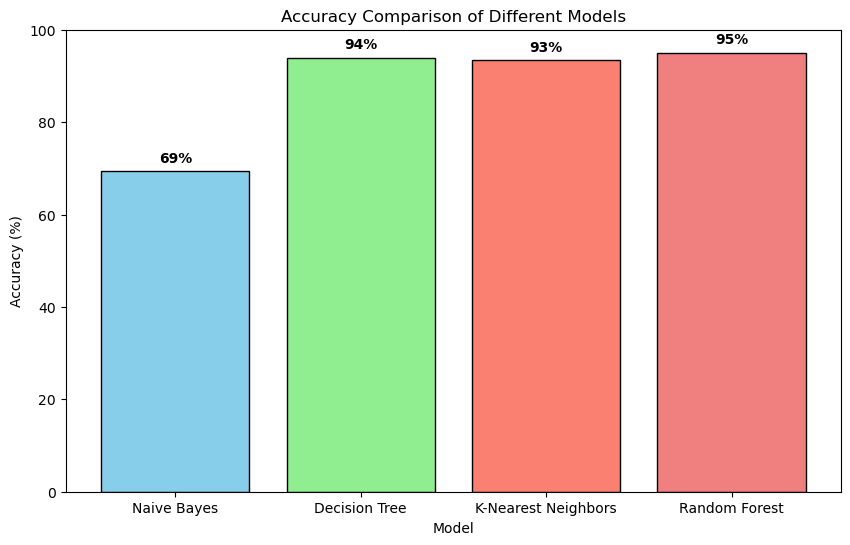

In [283]:
# Bar-plot comparing the model's accuracies
model_accuracies = {
    'Naive Bayes': nb_accuracy,  
    'Decision Tree': dt_accuracy, 
    'K-Nearest Neighbors': knn_accuracy,  
    'Random Forest': rf_accuracy  
}

# Converting accuracies to percentages
model_accuracies_percent = {model: accuracy * 100 for model, accuracy in model_accuracies.items()}

# Extracting model names and their corresponding accuracies in percentage
models = list(model_accuracies_percent.keys())
accuracies_percent = list(model_accuracies_percent.values())

# Defining a color palette for each model
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral']

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies_percent, color=colors, edgecolor='black')
plt.ylim(0, 100)  # Set the y-axis limit from 0 to 100 for percentage display

# Adding title and labels
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

# Displaying values on top of each bar as percentages
for i, v in enumerate(accuracies_percent):
    plt.text(i, v + 2, f"{v:.0f}%", ha='center', fontweight='bold')

# Showing the plot
plt.show()

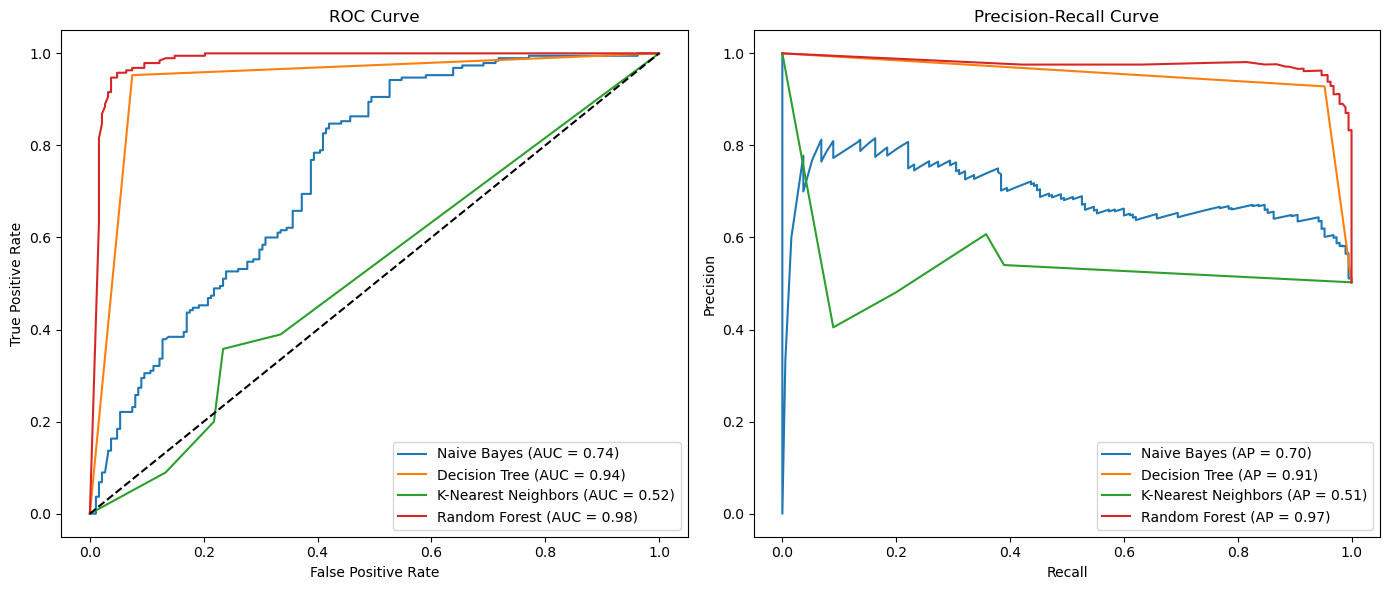

In [284]:
# ROC and PR curve
# Calculating predicted probabilities for the positive class (1) for each model
y_pred_proba_nb = gnb.predict_proba(X_test)[:, 1]
y_pred_proba_dt = dt_classifier.predict_proba(X_test)[:, 1]
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Storing the probabilities and model names in dictionaries for easy iteration
y_pred_probas = {
    "Naive Bayes": y_pred_proba_nb,
    "Decision Tree": y_pred_proba_dt,
    "K-Nearest Neighbors": y_pred_proba_knn,
    "Random Forest": y_pred_proba_rf
}

# Plotting ROC and PR curves
plt.figure(figsize=(14, 6))

# Subplot for ROC curve
plt.subplot(1, 2, 1)
for model_name, y_pred_proba in y_pred_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Subplot for Precision-Recall curve
plt.subplot(1, 2, 2)
for model_name, y_pred_proba in y_pred_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()